**I. Objective and Data**

We will use the OpenMIC-2018 dataset (https://zenodo.org/records/1432913) which contains 10-second audio recordings of various musical instruments. Alongside the raw audio, the dataset also provides a processed version where each clip is represented by 128-dimensional vectors obtained from the VGGish embedding (a neural network model for feature extraction). Our goal is to examine recurrent neural networks (RNNs) with varying architectures to classify instruments and evaluate which design achieves the best classification performance.

Recurrent neural networks are a natural choice for this problem because the VGGish embeddings preserve the temporal structure of the audio clips. By processing the sequence of feature frames, RNNs can capture temporal patterns and dependencies that distinguish different instruments, making them well-suited for sequence-based classification.

In [1]:
from pandas import read_csv, DataFrame, merge
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
import json
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

For this study, we restrict attention to audio samples that human verifiers unanimously labeled as containing a single instrument. Each clip’s VGGish embedding divides the 10-second sample into 10 time frames, with each frame represented by a 128-dimensional feature vector. In our data representation, the columns are named vggish_$j$_f$k$, where $j$ is the feature index and $k$ is the frame index of the clip.

In [2]:
def get_data(reprocess):
    #if reprocess = True, build the dataframe from the source csv files, save this dataframe
    #if reproces = False, build the dataframe from the saved dataframe
    
    if reprocess:
        path = "openmic-2018"
        file = "openmic-2018-aggregated-labels.csv"
        df_labels = read_csv(os.path.join(path,file))
        df_labels = df_labels.rename(columns={"sample_key":"clip_id"})
    
        #audio clips with single instrument
        df_unique = (df_labels.groupby('clip_id').filter(lambda g: g["instrument"].nunique() == 1)).reset_index(drop=True)
        df_unique = df_unique[["clip_id","instrument"]]
    
        vggish_folder_path = os.path.join(path,"vggish")
        rows = []
        for clip_id in df_unique['clip_id']:
            folder = clip_id[:3]
            subfolder = os.path.join(vggish_folder_path,folder)
            file = clip_id + ".json"
            file_path = os.path.join(subfolder,file)
            
            with open(file_path,'r') as f:
                data = json.load(f)
                
            frames = data['features']  # shape: (n_frames, 128)
            row_data = [clip_id]
            for frame in frames:
                row_data += frame
            
            rows.append(row_data)
    
        columns = ['clip_id']
        for j in range(len(frames)):      
            columns += [f'vggish_{i}_f{j}' for i in range(128)]
        df_data = DataFrame(rows, columns=columns)
        df = merge(df_data, df_unique, on='clip_id', how='inner')
        df.to_csv("data_single_instrument_vggish_embedding.csv")   
    else:
        df = read_csv("data_single_instrument_vggish_embedding.csv")  
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
        
    return df

In [3]:
df_full = get_data(False)
df_full.head()

,clip_id,vggish_0_f0,vggish_1_f0,vggish_2_f0,vggish_3_f0,vggish_4_f0,vggish_5_f0,vggish_6_f0,vggish_7_f0,vggish_8_f0,...,vggish_119_f9,vggish_120_f9,vggish_121_f9,vggish_122_f9,vggish_123_f9,vggish_124_f9,vggish_125_f9,vggish_126_f9,vggish_127_f9,instrument
0,000139_119040,190,44,215,107,201,68,75,69,102,...,86,255,255,235,95,255,0,105,255,accordion
1,000145_172800,182,26,194,95,195,125,122,94,98,...,95,255,43,123,42,158,0,0,255,accordion
2,000154_288000,175,9,151,95,166,35,117,134,132,...,117,68,89,12,168,114,0,22,255,mallet_percussion
3,000178_3840,171,34,165,96,228,44,121,99,126,...,216,53,131,183,69,178,208,0,255,voice
4,000189_207360,181,17,170,113,191,88,110,134,83,...,99,177,136,204,46,255,0,66,255,guitar


In [4]:
counts = df_full['instrument'].value_counts()
counts

instrument
mallet_percussion    731
flute                669
piano                643
organ                623
saxophone            554
accordion            535
bass                 529
cymbals              512
cello                490
violin               487
voice                458
ukulele              404
synthesizer          378
banjo                378
guitar               356
drums                342
trombone             204
mandolin             172
clarinet             155
trumpet               68
Name: count, dtype: int64

Since the dataset includes many instruments with uneven numbers of observations, we simplify the classification task by focusing on the ten instruments with the largest sample counts. This reduces training complexity while still providing a diverse set of instrument categories for evaluation.

In [5]:
top_10_instruments = df_full['instrument'].value_counts()[:10].index.tolist()
print(top_10_instruments)
df_v1 = df_full[df_full['instrument'].isin(top_10_instruments)].reset_index()

feature_cols = [c for c in df_v1.columns if c.startswith("vggish_")]
label_col = "instrument"

X_flat = df_v1[feature_cols].to_numpy(dtype="float32")  # shape (N, 1280)
y = df_v1[label_col].to_numpy()
X = X_flat.reshape(-1, 10, 128)

encoder = LabelEncoder()
y = encoder.fit_transform(y)   # now integers
num_classes = len(encoder.classes_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(len(X_train),len(X_test))

['mallet_percussion', 'flute', 'piano', 'organ', 'saxophone', 'accordion', 'bass', 'cymbals', 'cello', 'violin']
4618 1155


**II. Simple RNN**

As our base model, we first consider a simple RNN (SimpleRNN) architecture. SimpleRNNs represent the most straightforward form of recurrent neural networks, where the hidden state is updated at each time step by a linear transformation of the input and the previous hidden state, followed by a nonlinearity. Although SimpleRNNs often struggle with long-term dependencies due to vanishing gradients, they remain a natural starting point for sequence classification tasks. Using SimpleRNN as a baseline allows us to benchmark how much performance can be achieved with the simplest recurrent structure before moving to more advanced variants such as GRUs and LSTMs.

In [62]:
#helper functions
def create_and_fit_model(model,epochs,batch_size,verbose):

    model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose)

    return history

def merge_histories(histories):
    merged = {}
    for key in histories[0].history.keys():
        merged[key] = []
    for hist in histories:
        for key, values in hist.history.items():
            merged[key].extend(values)
    return merged

def plot_(histories):

    if not isinstance(histories, list):
        histories = [histories]
    
    # Merge histories
    merged = merge_histories(histories)

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(merged['accuracy'], label='Training Accuracy')
    plt.plot(merged['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(merged['loss'], label='Training Loss')
    plt.plot(merged['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid()
    
    plt.tight_layout()
    plt.show()

def avg_last_fraction_accuracy(histories, fraction=0.1):

    if not isinstance(histories, list):
        histories = [histories]
    
    merged = merge_histories(histories)
    n_epochs = len(merged['accuracy'])
    n_last = max(1, int(n_epochs * fraction))  # at least 1 epoch
    
    avg_acc = sum(merged['accuracy'][-n_last:]) / n_last
    avg_val_acc = sum(merged['val_accuracy'][-n_last:]) / n_last
    
    return avg_acc, avg_val_acc

In [8]:
feature_dim = 128
time_frames = 10

layer_1_units = int(feature_dim/2) #64
layer_2_units = int(layer_1_units/2) #32
layer_3_units = int(layer_2_units/2) #16

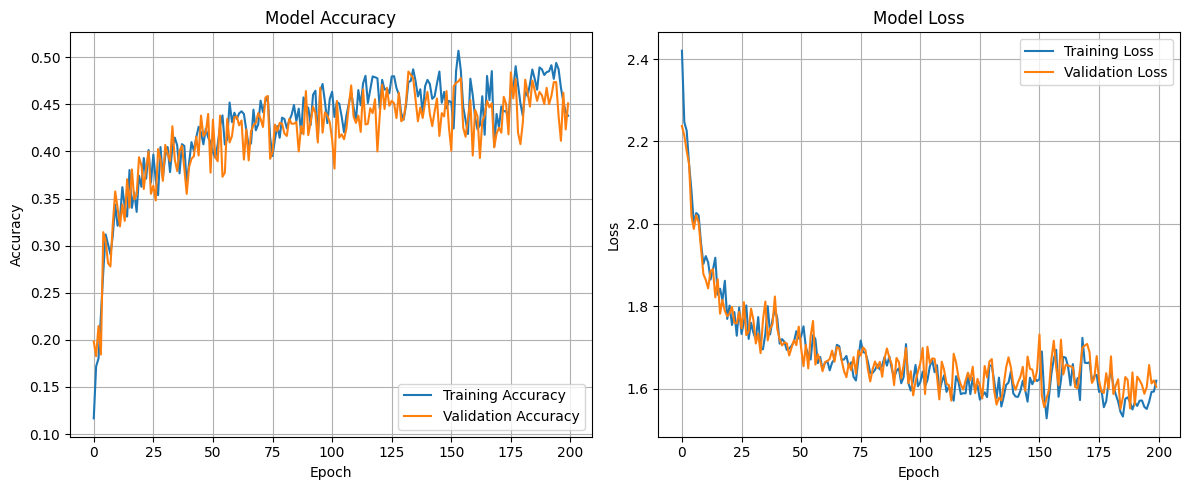

In [ ]:
model = models.Sequential([
    layers.SimpleRNN(layer_1_units, input_shape=(time_frames, feature_dim)),   
    layers.Dense(num_classes, activation='softmax')
])

history = create_and_fit_model(model,200,50,0)
plot_(history)

We begin with a single layer of SimpleRNN with 64 units, half of the original feature dimension (128). The training and validation accuracies plateau around 100 epochs, but remain below 50%, performing worse than random guessing.

Next, keeping the configuration constant except for the architecture, we add another SimpleRNN layer with units equal to half of the preceding layer’s size. With this modification, training and validation accuracies improve to the 70%–80% range at 120 epochs. Adding yet another layer with 16 units (half of the previous layer) leads to similar results.

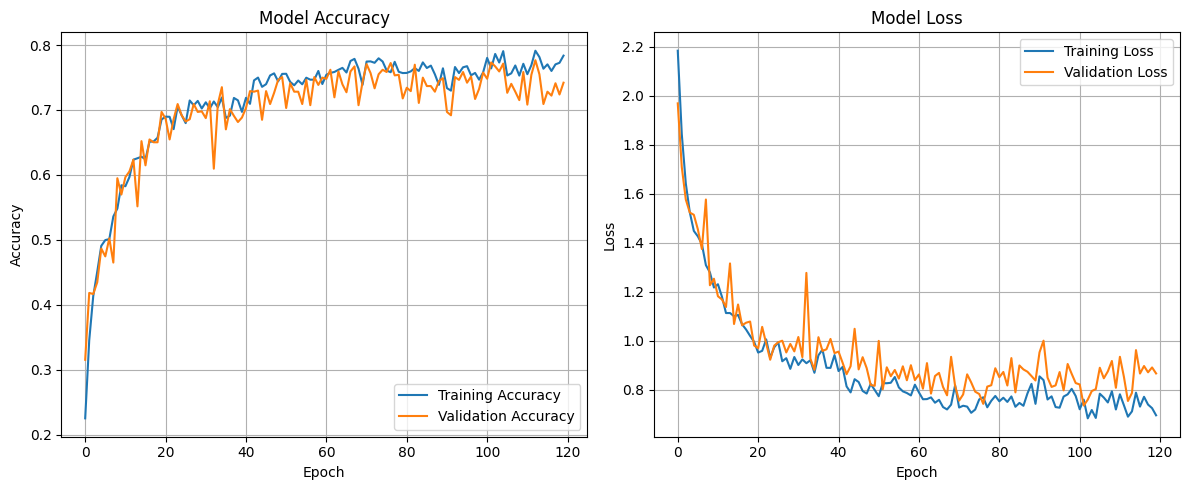

In [29]:
layer_1_units = int(feature_dim/2)
layer_2_units = int(layer_1_units/2)
model = models.Sequential([
    layers.SimpleRNN(layer_1_units, return_sequences=True, input_shape=(time_frames, feature_dim)),
    layers.SimpleRNN(layer_2_units),
    layers.Dense(num_classes, activation='softmax')
])

epochs = 120
batch_size = 50
verbose = 0
history = create_and_fit_model(model,epochs,batch_size,verbose)
plot_(history)

For consistency, we restrict training to 120 epochs with a batch size of 50. From the model loss curves, we can infer whether extending training (increasing epochs) could further improve performance depending on whether the training and validation losses appear to have plateaued. However, adding an additional layer with progressively fewer units did not significantly improve accuracy compared to the two-layer configuration.

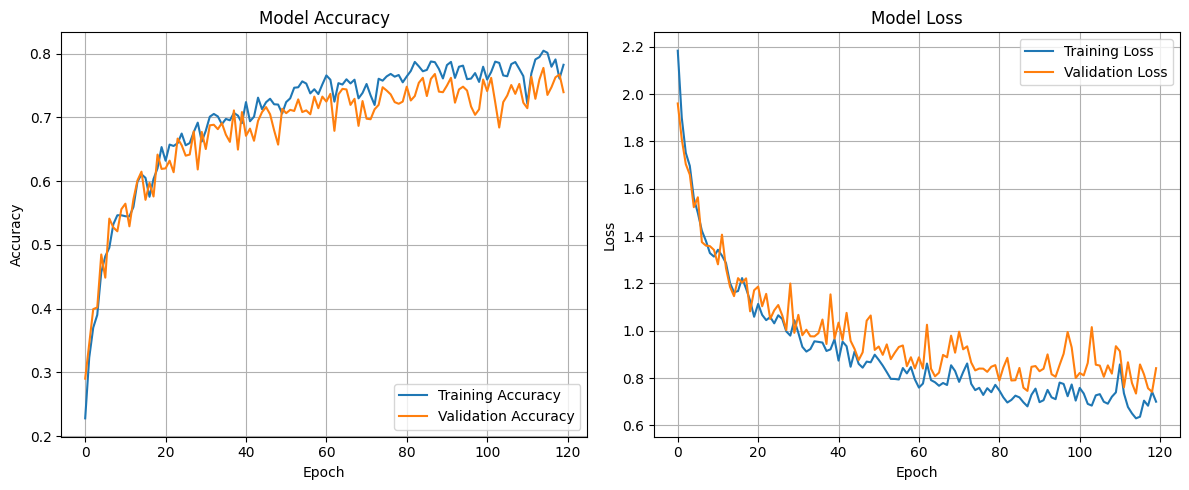

In [32]:
model = models.Sequential([
    layers.SimpleRNN(layer_1_units, return_sequences=True, input_shape=(time_frames, feature_dim)),  
    layers.SimpleRNN(layer_2_units, return_sequences=True),
    layers.SimpleRNN(16),
    layers.Dense(num_classes, activation='softmax')
])

history = create_and_fit_model(model,epochs,batch_size,verbose)
plot_(history)

**III. Simple RNN with dropouts**

One of the common challenges in training neural networks is overfitting, where the model memorizes training examples rather than learning generalizable patterns. Dropout is a standard regularization technique that addresses this by randomly setting a fraction of units to zero during training, thereby preventing co-adaptation of neurons and encouraging the network to learn more robust representations. In recurrent networks, however, the temporal nature of the hidden states introduces an additional risk of overfitting through the recurrent connections. To address this, Keras and similar frameworks provide the recurrent_dropout parameter, which randomly drops connections specifically within the recurrent state updates. This can reduce reliance on specific temporal dependencies and potentially improve generalization.

To test this, we return to the two-layer SimpleRNN architecture discussed above and introduce recurrent dropout by varying the recurrent_dropout parameter. Even with training extended to 200 epochs, modest recurrent dropout rates of 0.05, 0.10, and 0.15 do not yield significant improvements in model accuracy. We then apply dropout in the feedforward connections (via the dropout parameter), but again find that conservative dropout values fail to improve performance.

In [39]:
dropouts = [0.05,0.1,0.15]
histories = []
epochs = 200

for dropout in dropouts:

    print(dropout)
    model = models.Sequential([
        layers.SimpleRNN(layer_1_units, recurrent_dropout=dropout, return_sequences=True, input_shape=(time_frames, feature_dim)),
        layers.SimpleRNN(layer_2_units, recurrent_dropout=dropout),
        layers.Dense(num_classes, activation='softmax')
    ])

    history = create_and_fit_model(model,epochs,batch_size,verbose)
    histories.append(history)

0.05
0.1
0.15


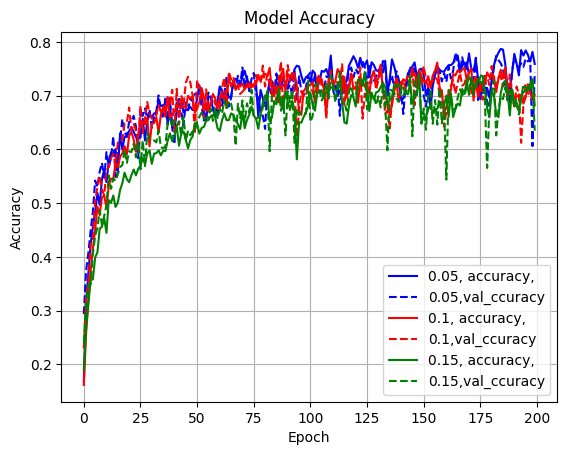

In [40]:
colors = ["b","r","g"]
for i in range(3):

    plt.plot(histories[i].history['accuracy'], color=colors[i], label=str(dropouts[i])+', accuracy,')
    plt.plot(histories[i].history['val_accuracy'], color=colors[i], label=str(dropouts[i])+',val_ccuracy',ls="--")
    plt.title('Model Accuracy')
    
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [41]:
dropouts = [0.05,0.1,0.15]
histories = []
epochs = 200

for dropout in dropouts:

    print(dropout)
    model = models.Sequential([
        layers.SimpleRNN(layer_1_units, dropout=dropout, return_sequences=True, input_shape=(time_frames, feature_dim)),
        layers.SimpleRNN(layer_2_units, dropout=dropout),
        layers.Dense(num_classes, activation='softmax')
    ])

    history = create_and_fit_model(model,epochs,batch_size,verbose)
    histories.append(history)

0.05
0.1
0.15


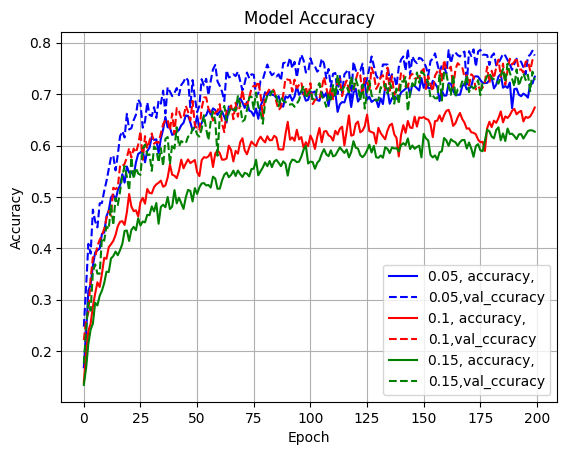

In [42]:
colors = ["b","r","g"]
for i in range(3):

    plt.plot(histories[i].history['accuracy'], color=colors[i], label=str(dropouts[i])+', accuracy,')
    plt.plot(histories[i].history['val_accuracy'], color=colors[i], label=str(dropouts[i])+',val_ccuracy',ls="--")
    plt.title('Model Accuracy')
    
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In summary, while dropout and recurrent dropout are often effective regularization strategies, in this case they do not provide a meaningful boost to classification accuracy. This suggests that the model’s limitations may be more architectural in nature (e.g., SimpleRNN’s difficulty in capturing long-term dependencies) rather than purely due to overfitting.

**IV. RNN with LSTM layer**

A well-known limitation of SimpleRNNs is their inability to capture long-term dependencies due to the vanishing gradient problem. This makes them less effective for sequential data where relevant information may span many time steps. To address this, we turn to the Long Short-Term Memory (LSTM) architecture, which introduces gating mechanisms (input, output, and forget gates) that regulate the flow of information through time. These gates enable the network to selectively retain or discard information, making LSTMs far more effective at modeling longer-term temporal dependencies compared to SimpleRNNs.

We first train a single LSTM layer with 64 units. Even with this basic configuration, we achieve training and validation accuracies in the 70%–80% range, with the loss curves plateauing around 125 epochs. This already represents a significant improvement over SimpleRNNs.

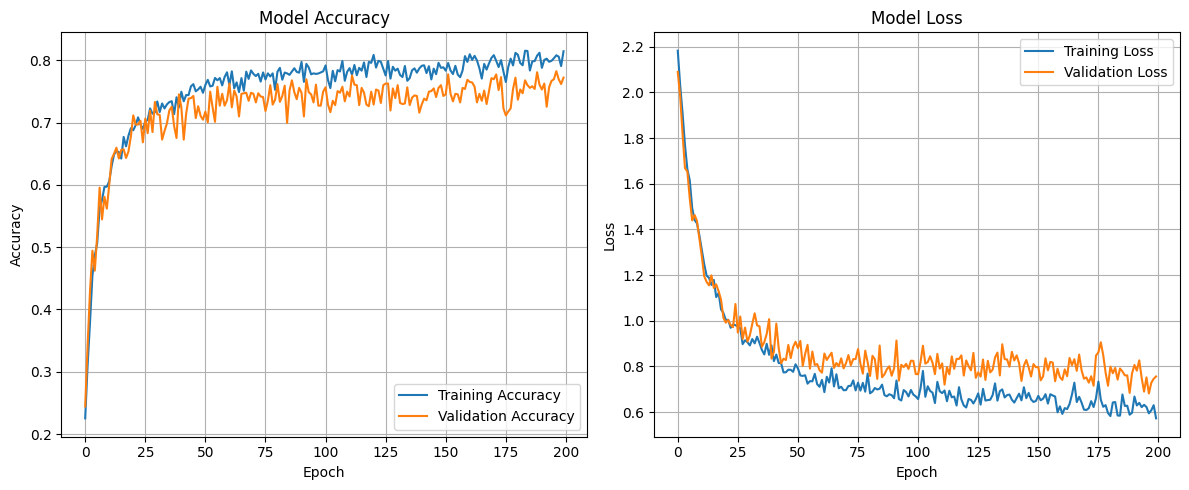

In [33]:
model = models.Sequential([
    layers.LSTM(layer_1_units, input_shape=(time_frames, feature_dim)),   
    layers.Dense(num_classes, activation='softmax')  
])

epochs = 200
history = create_and_fit_model(model,epochs,batch_size,verbose)
plot_(history)

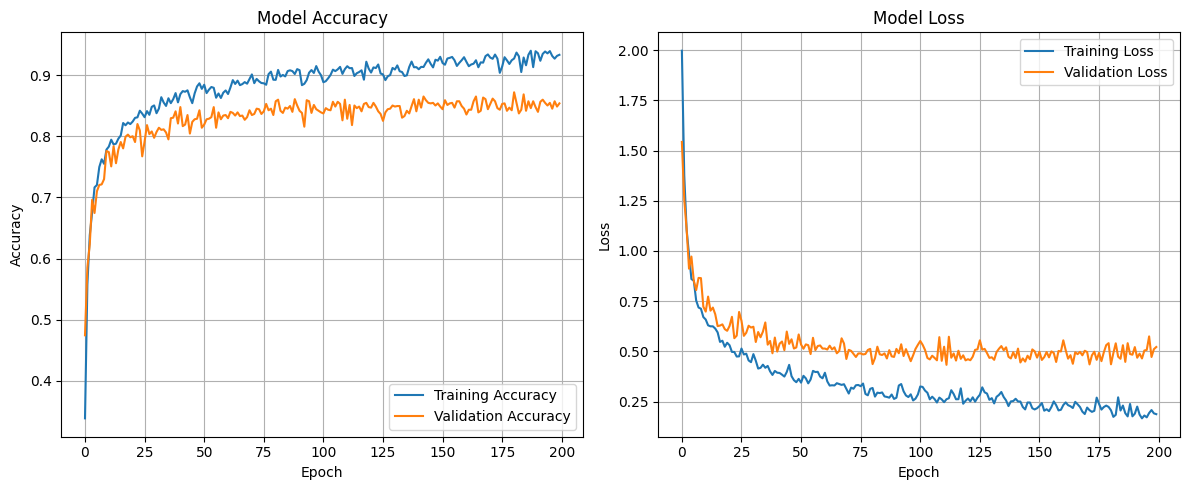

In [34]:
#two layers of LSTM

model = models.Sequential([
    layers.LSTM(layer_1_units, return_sequences = True, input_shape=(time_frames, feature_dim)),   
    layers.LSTM(layer_2_units),   
    layers.Dense(num_classes, activation='softmax')  
])

history = create_and_fit_model(model,epochs,batch_size,verbose)
plot_(history)

Adding a second LSTM layer with 32 units further boosts performance, with training accuracy exceeding 90% and validation accuracy surpassing 80%. However, the growing gap between training and validation accuracy suggests potential overfitting. To mitigate this, we introduce dropout regularization in the first layer. With a dropout rate of 0.10, the training accuracy decreases slightly to the 80%–90% range, but the gap between training and validation narrows, reducing overfitting.

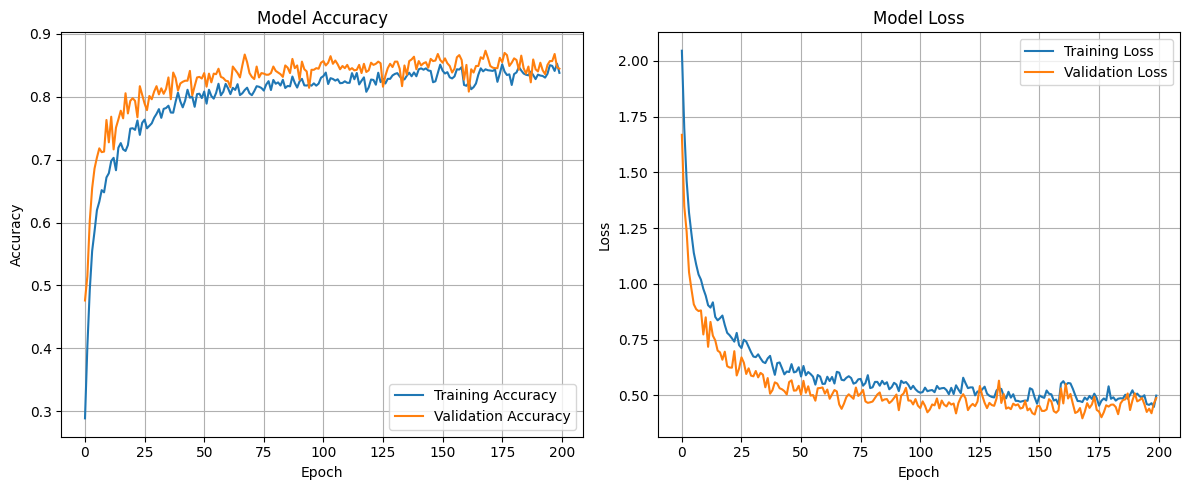

In [64]:
#adding 10% dropout in first layer

model = models.Sequential([
    layers.LSTM(layer_1_units, dropout = 0.10, return_sequences = True, input_shape=(time_frames, feature_dim)),   
    layers.LSTM(layer_2_units),   
    layers.Dense(num_classes, activation='softmax')  
])

epochs = 200
history = create_and_fit_model(model,epochs,batch_size,verbose)
plot_(history)

In [65]:
avg_last_fraction_accuracy(history)

(0.8381766885519027, 0.8485714286565781)

Next, we experiment with increasing regularization by (i) applying a dropout of 0.10 in the second layer, (ii) raising dropout in the first layer to 0.20, and (iii) applying 0.10 recurrent dropout in the first layer. Neither configuration improves performance relative to the simpler setup with only 0.10 dropout in the first layer.

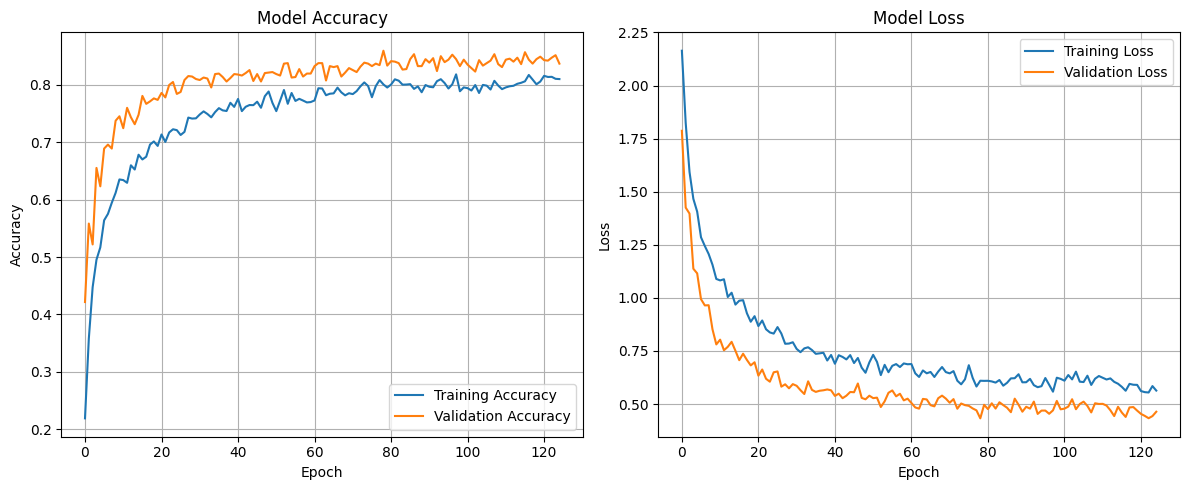

In [41]:
#10% dropout in the two LSTM layers

model = models.Sequential([
    layers.LSTM(layer_1_units, dropout = 0.10, return_sequences = True, input_shape=(time_frames, feature_dim)),   
    layers.LSTM(layer_2_units, dropout = 0.10),   
    layers.Dense(num_classes, activation='softmax')  
])

epochs = 125
history = create_and_fit_model(model,epochs,batch_size,verbose)
plot_(history)

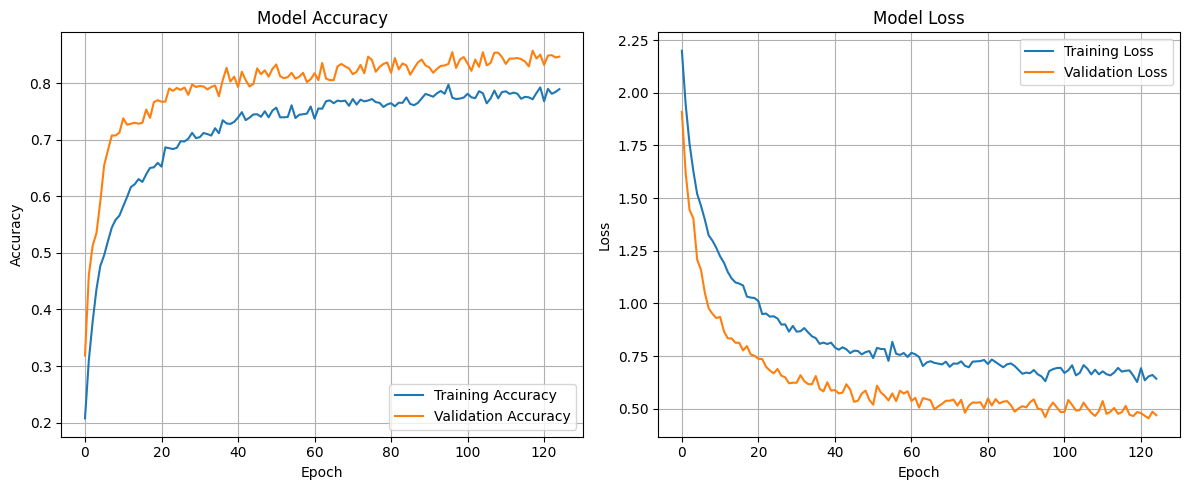

In [42]:
#20% dropout in the first LSTM layer

model = models.Sequential([
    layers.LSTM(layer_1_units, dropout = 0.20, return_sequences = True, input_shape=(time_frames, feature_dim)),   
    layers.LSTM(layer_2_units),   
    layers.Dense(num_classes, activation='softmax')  
])

history = create_and_fit_model(model,125,batch_size,verbose)
plot_(history)

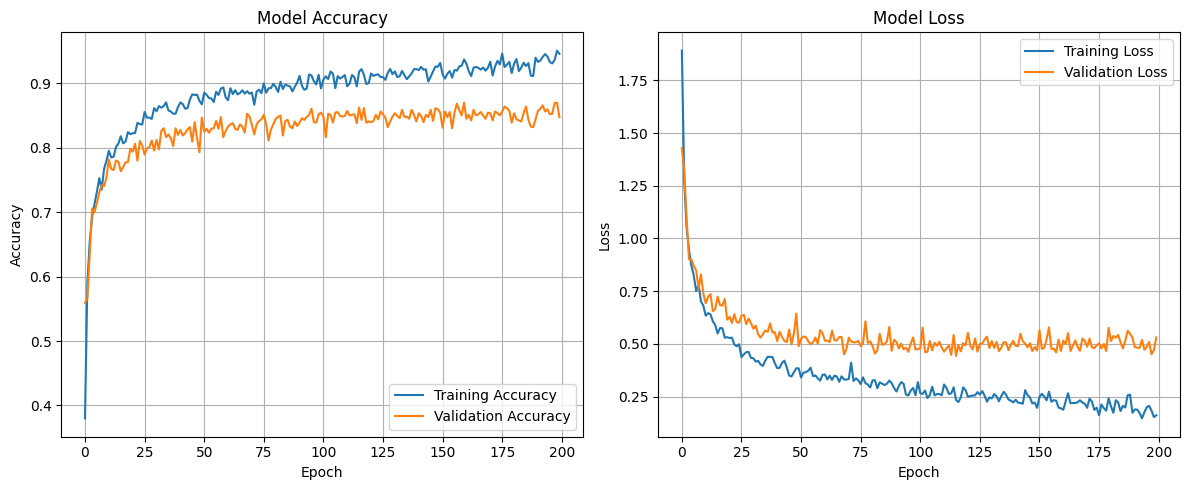

In [44]:
#10% recurrent dropout in the first layer

model = models.Sequential([
    layers.LSTM(layer_1_units, recurrent_dropout = 0.10, return_sequences = True, input_shape=(time_frames, feature_dim)),   
    layers.LSTM(layer_2_units),   
    layers.Dense(num_classes, activation='softmax')  
])

epochs = 200
history = create_and_fit_model(model,epochs,batch_size,verbose)
plot_(history)

We then explore recurrent dropout, which regularizes the recurrent connections themselves. Setting a recurrent dropout of 0.10 in the first layer improves both training and validation accuracies, yielding (86.0%, 85.5%). Compared to the formerly best case with 10% dropout in the first layer with accuracies (83.8%,84.9%), recurrent dropout appears more effective in this setting, possibly because it directly targets overfitting in the temporal dynamics.

In summary, LSTMs already outperform SimpleRNNs on this task, and modest regularization via recurrent dropout helps improve generalization further without substantially sacrificing training performance.

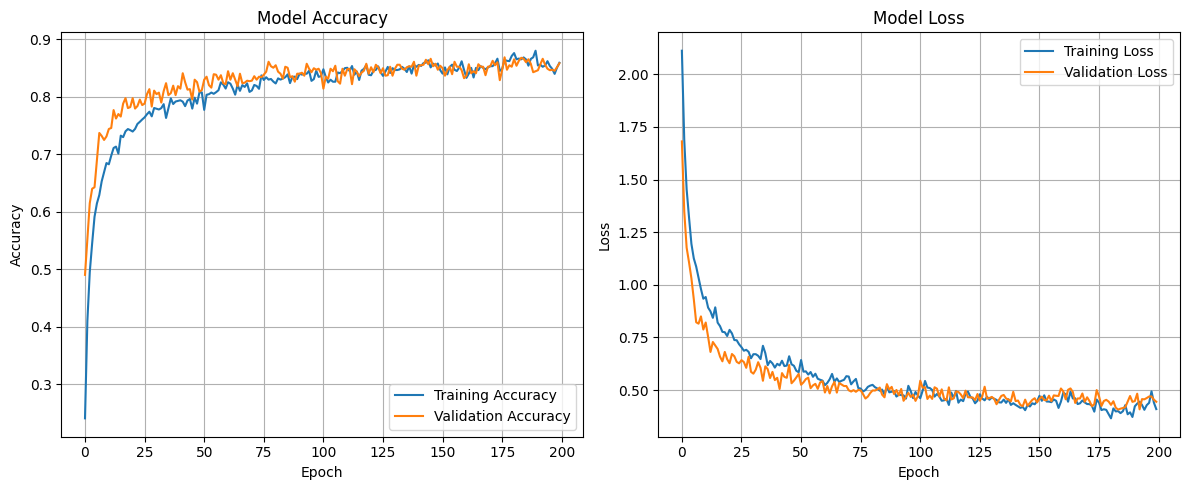

In [57]:
model = models.Sequential([
    layers.LSTM(layer_1_units, dropout=0.10, recurrent_dropout = 0.10, return_sequences = True, input_shape=(time_frames, feature_dim)),   
    layers.LSTM(layer_2_units),   
    layers.Dense(num_classes, activation='softmax')  
])

epochs = 200
history = create_and_fit_model(model,epochs,batch_size,verbose)
plot_(history)

In [63]:
avg_last_fraction_accuracy(history)

(0.8599610239267349, 0.855064931511879)

**V. RNN with GRU layer**

Since LSTMs demonstrated clear improvements over SimpleRNNs, we next consider the Gated Recurrent Unit (GRU) architecture. GRUs are closely related to LSTMs but employ a simpler gating mechanism that merges the input and forget gates into a single update gate. This reduction in complexity makes GRUs faster to train and less computationally demanding, while still retaining the ability to capture long-term dependencies in sequential data.

We begin with a single GRU layer of 64 units. Compared to the SimpleRNN baseline in Section II, the GRU shows better performance, but it falls slightly short of the LSTM results in Section IV.

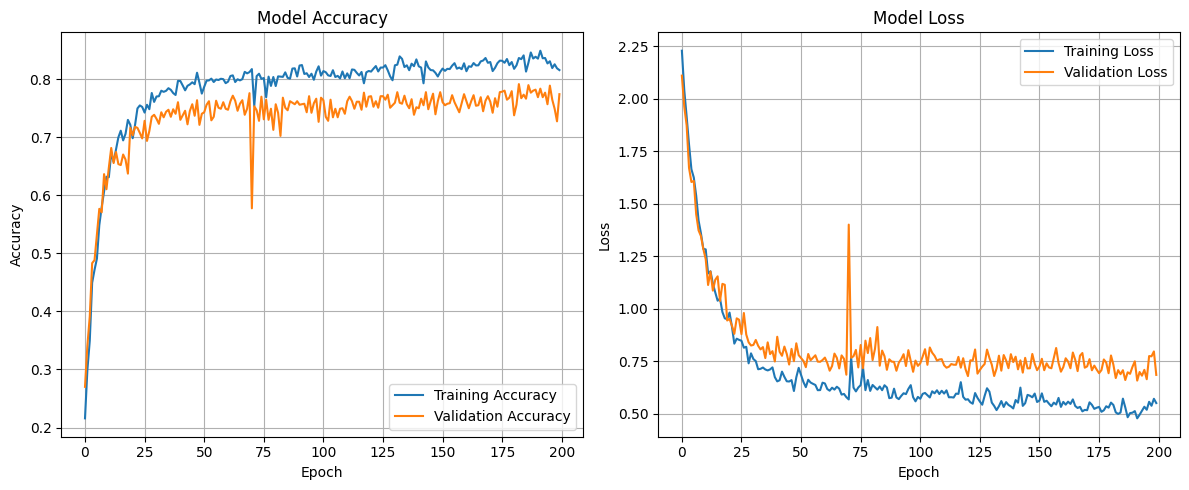

In [66]:
model = models.Sequential([
    layers.GRU(layer_1_units, input_shape=(time_frames, feature_dim)),   
    layers.Dense(num_classes, activation='softmax')  
])

epochs = 200
history = create_and_fit_model(model,epochs,batch_size,verbose)
plot_(history)

Following the improvements seen in the LSTM experiments, we next consider a two-layer GRU model with 64 and 32 units, and apply dropout of 0.10 to the first layer. This configuration reduces overfitting and achieves more balanced training and validation accuracies.  

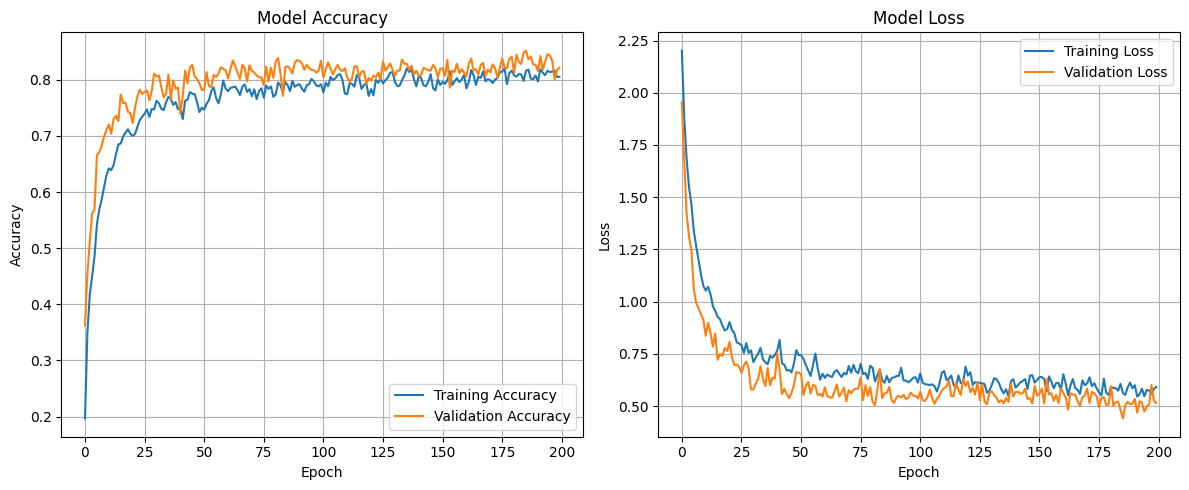

In [67]:
model = models.Sequential([
    layers.GRU(layer_1_units, dropout = 0.1, return_sequences=True, input_shape=(time_frames, feature_dim)),
    layers.GRU(layer_2_units),
    layers.Dense(num_classes, activation='softmax')  
])

epochs = 200
history = create_and_fit_model(model,epochs,batch_size,verbose)
plot_(history)

Finally, we extend the model by introducing a recurrent dropout of 0.10 to the first layer. With this setting, the training and validation accuracies are (82.4%, 82.9%), indicating improved generalization compared to the single-layer model. However, these results remain slightly weaker than the best-performing LSTM configuration, which reached (86.0%, 85.5%).

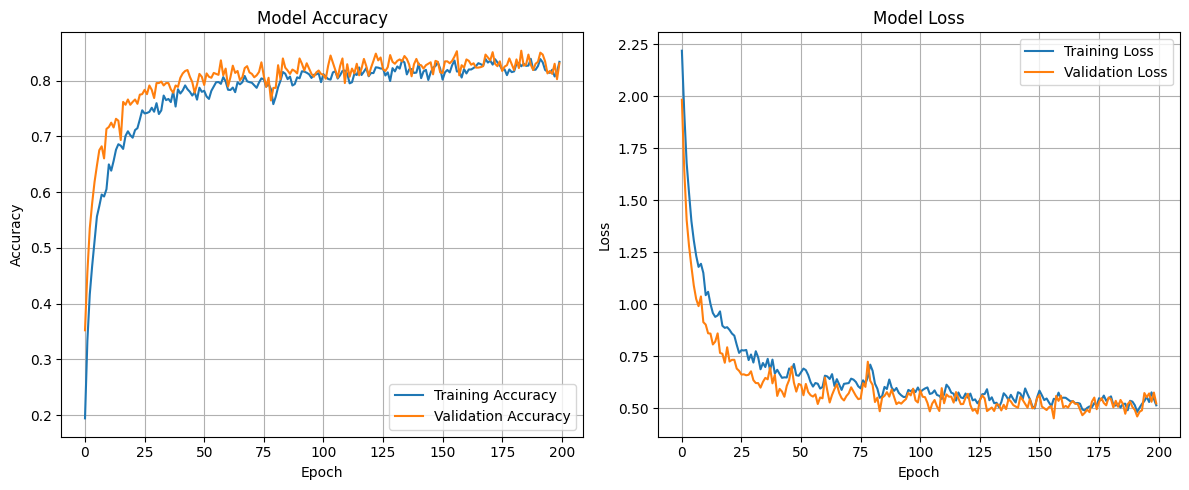

In [68]:
model = models.Sequential([
    layers.GRU(layer_1_units, recurrent_dropout=0.1, dropout = 0.1, return_sequences=True, input_shape=(time_frames, feature_dim)),
    layers.GRU(layer_2_units),
    layers.Dense(num_classes, activation='softmax')  
])

epochs = 200
history = create_and_fit_model(model,epochs,batch_size,verbose)
plot_(history)

In [69]:
avg_last_fraction_accuracy(history)

(0.8244911134243011, 0.8292640686035156)

In summary, GRUs offer a computationally simpler alternative to LSTMs and can achieve reasonable performance with less overfitting. However, in this dataset, LSTMs consistently outperform GRUs in terms of classification accuracy.

**VI. Summary and Insights** 

In this mini-project, we evaluated recurrent neural network architectures — SimpleRNN, LSTM, and GRU — for the classification of musical instruments using the OpenMIC-2018 dataset with VGGish embeddings. The SimpleRNN models provided a useful baseline, but their limited capacity to capture long-term dependencies resulted in relatively low performance. LSTMs significantly improved both training and validation accuracies, with careful use of dropout and recurrent dropout helping to reduce overfitting. GRUs, while computationally simpler, achieved balanced results but did not surpass the LSTM configurations in this case.

These findings suggest that while deeper or more regularized RNNs improve performance, there is a trade-off between model complexity, training cost, and accuracy. The LSTM architecture proved most effective for this dataset, indicating that its gating mechanisms are well suited for handling sequential embeddings derived from audio.

For future work, several avenues are promising. First, the reliance on VGGish embeddings may have discarded information that could be useful for classification; working directly with raw audio features (e.g., spectrograms or mel-frequency cepstral coefficients) could unlock further improvements. Second, exploring more advanced architectures such as bidirectional RNNs, attention mechanisms, or transformer-based models may capture richer temporal dependencies. Finally, techniques like data augmentation, transfer learning from pre-trained audio models, and hyperparameter optimization could further enhance generalization and robustness across instrument classes.